In [ ]:
# Import required packages
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from pathlib import Path

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds

from keras import layers, models
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization, Activation

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## 1. Load the datasets

In your shared folder, right click 'ads_proj3' and hit add shortcut to gdrive. Make sure you add the shortcut to the 'MyDrive' folder.

In [ ]:
root = "/gdrive/MyDrive/ads_proj3/spring-2022-prj3-group9/"
outputs_dir = root + "output"

In [ ]:
assert os.path.exists(root), 'Check the path to your root directory'

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [ ]:
train_images = os.path.join(root, 'data/train_data/images/')
clean_images_labels = os.path.join(root, 'data/train_data/clean_labels.csv')
noisy_images_labels = os.path.join(root, 'data/train_data/noisy_labels.csv')

In [ ]:
assert os.path.exists(train_images)
assert os.path.exists(clean_images_labels)
assert os.path.exists(noisy_images_labels)

The following cells are unnecessary to run if data has been processed into .npy files (see load_save_data.py in the lib folder). Running the following cells on Google Colab is extremely time consuming and uploading the data required will also be time consuming. Instead, please see load_save_data.py, create the necessary .npy files, and skip to section 1.2 Load npy files.

In [ ]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    if i % 1000 == 0:
      print('.', end='')
    img_fn = train_images+f'{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt(clean_images_labels, delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt(noisy_images_labels, delimiter=',', dtype="int8")

..................................................

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


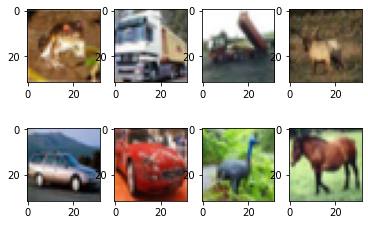

In [ ]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


### 1.2 Loading saved npy files

In [ ]:
outputs_dir = root + 'output'
clean_imgs = np.load(outputs_dir+'/clean_img.npy')
noisy_imgs = np.load(outputs_dir+'/noisy_img.npy')
aug_imgs = np.load(outputs_dir+'/aug_clean_img.npy')
combined_imgs = np.vstack((clean_imgs,noisy_imgs,aug_imgs))

In [ ]:
# delete large variables
del aug_imgs

In [ ]:
# load labels
combined_labels = np.load(outputs_dir+'/combined_labels.npy')

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

The baseline LR model is only trained on the noisy data.

In [ ]:
# get labels
orig_labels = combined_labels[:50000]

In [ ]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
def make_histogram(imgs, n_img):

  no_bins = 6
  bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
  feature_mtx = np.empty((n_img,3*(len(bins)-1)))
  i = 0
  for i in range(n_img):
      
      # Use the numbers of pixels in each bin for all three channels as the features
      feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
      feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
      feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
      
      # Concatenate three features
      feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
      i += 1

  return feature_mtx

In [ ]:
train_mtx = make_histogram(combined_imgs[:50000], 50000)

In [ ]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(train_mtx, orig_labels)

In [ ]:
# save the trained baseline model
import pickle
filename = 'baseline.sav'
pickle.dump(clf, open(outputs_dir + "/" + filename, 'wb'))

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [ ]:
# [DO NOT MODIFY THIS CELL]
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_imgs, 
                                                    combined_labels, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [ ]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
def CNN(input_size=(32,32,3)):

  model = Sequential()
  model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', input_shape=input_size))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())

  model.add(Dense(256, kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='Nadam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [ ]:
model1 = CNN()

In [ ]:
start = time.time()
history1 = model1.fit(X_train, 
                      y_train, 
                      validation_data=(X_test, y_test),
                      epochs=20,
                      batch_size=256,
                      verbose=1)
end = time.time()
print("Training Time:", end-start)

Epoch 1/20
293/293 [==============================] - 19s 26ms/step - loss: 2.0703 - accuracy: 0.2924 - val_loss: 2.0054 - val_accuracy: 0.3120
Epoch 2/20
293/293 [==============================] - 7s 22ms/step - loss: 1.8844 - accuracy: 0.3814 - val_loss: 1.8158 - val_accuracy: 0.4158
Epoch 3/20
293/293 [==============================] - 7s 22ms/step - loss: 1.7719 - accuracy: 0.4398 - val_loss: 1.7585 - val_accuracy: 0.4539
Epoch 4/20
293/293 [==============================] - 7s 23ms/step - loss: 1.6902 - accuracy: 0.4795 - val_loss: 1.6796 - val_accuracy: 0.4998
Epoch 5/20
293/293 [==============================] - 7s 22ms/step - loss: 1.6239 - accuracy: 0.5084 - val_loss: 1.7433 - val_accuracy: 0.4544
Epoch 6/20
293/293 [==============================] - 6s 22ms/step - loss: 1.5761 - accuracy: 0.5299 - val_loss: 1.6188 - val_accuracy: 0.5244
Epoch 7/20
293/293 [==============================] - 7s 22ms/step - loss: 1.5310 - accuracy: 0.5466 - val_loss: 1.5753 - val_accuracy: 0.548

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)

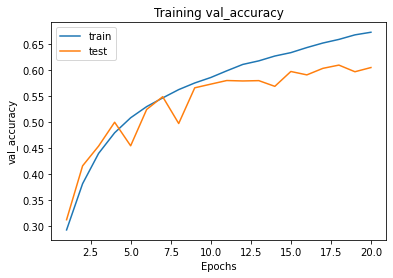

In [ ]:
plot_metric(history1, "accuracy")
plot_metric(history1, "val_accuracy")
plt.legend(["train", "test"])

In [ ]:
# save model 1
model1.save(outputs_dir + "/" + 'model1.h5')

In [ ]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    return model1.predict(image)

### 2.3. Model II

In [ ]:
clean_aug = np.vstack((clean_imgs, aug_imgs))
clean_aug_labels = np.concatenate((combined_labels[:10000], combined_labels[50000:]))

In [ ]:
clean_aug = clean_aug / 255

In [ ]:
del aug_imgs
del clean_imgs

In [ ]:
clean_model = CNN()
clean_hist = clean_model.fit(clean_aug, 
                      clean_aug_labels, 
                      epochs=20,
                      batch_size=256,
                      verbose=1)

Epoch 1/20
235/235 [==============================] - 16s 22ms/step - loss: 1.6897 - accuracy: 0.3978
Epoch 2/20
235/235 [==============================] - 5s 21ms/step - loss: 1.2689 - accuracy: 0.5469
Epoch 3/20
235/235 [==============================] - 5s 21ms/step - loss: 1.0527 - accuracy: 0.6271
Epoch 4/20
235/235 [==============================] - 5s 21ms/step - loss: 0.9125 - accuracy: 0.6787
Epoch 5/20
235/235 [==============================] - 5s 21ms/step - loss: 0.8039 - accuracy: 0.7164
Epoch 6/20
235/235 [==============================] - 5s 21ms/step - loss: 0.7215 - accuracy: 0.7472
Epoch 7/20
235/235 [==============================] - 5s 21ms/step - loss: 0.6482 - accuracy: 0.7729
Epoch 8/20
235/235 [==============================] - 5s 21ms/step - loss: 0.5859 - accuracy: 0.7981
Epoch 9/20
235/235 [==============================] - 5s 21ms/step - loss: 0.5286 - accuracy: 0.8167
Epoch 10/20
235/235 [==============================] - 5s 21ms/step - loss: 0.4800 - accur

In [ ]:
# save the cleaning model
clean_model.save(outputs_dir + "/" + "labelclean2.h5")

In [ ]:
# predicted new labels on noisy data
noisy_imgs = noisy_imgs / 255

In [ ]:
import time
start = time.time()
# predict labels
new_pred = clean_model.predict(noisy_imgs).argmax(axis=1)
end = time.time()
print(f"Total Label Network prediction Time: {end-start}")

Total Label Network prediction Time: 3.63273286819458


In [ ]:
cleaned = np.concatenate((combined_labels[:10000], new_pred, combined_labels[50000:]))
np.save(outputs_dir+"/cleaned_labels2.npy", cleaned)

In [ ]:
del noisy_imgs
del combined_labels
del clean_aug
del clean_aug_labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_imgs, 
                                                    cleaned, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [ ]:
del combined_imgs
del cleaned

In [ ]:
X_train, X_test = X_train/255, X_test/255

In [ ]:
clean_images_labels = os.path.join(root, 'data/train_data/clean_labels.csv')
noisy_images_labels = os.path.join(root, 'data/train_data/noisy_labels.csv')
clean_labels = np.genfromtxt(clean_images_labels, delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt(noisy_images_labels, delimiter=',', dtype="int8")

In [ ]:
clean = np.eye(10)[clean_labels]
noisy = np.eye(10)[noisy_labels[:10000]]
clean_imgs = clean_imgs/255

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Lambda

#Custom loss function for comparing predicted class to clean label used for training label network 
def label_loss(y_true, y_pred):
    #distance between true labels and predicted labels
    loss = K.abs(y_true - y_pred)
    loss = K.sum(loss, axis = 1)
    loss = K.sum(loss)
    return loss 
    
def clean_label_model():
    img_input = Input(shape=(32, 32, 3))
    noisy_label = Input(shape = (10))
    
    #VGG16 Model For Transfer learning
    base = VGG16(include_top=False,weights="imagenet",input_shape=(32,32,3),pooling='max')

    #Trainable Layer
    base.trainable = False
    base.get_layer('block4_conv3').trainable = True
    base.get_layer('block5_conv3').trainable = True

    #VGG16 as the base model
    img_vec = base(img_input)

    noisy_l = Dense(10)(noisy_label)
    img_vec = Dense(256)(img_vec)
    
    # concatenate noisy labels and image features
    x = Concatenate(axis=-1)([noisy_l, img_vec])
    x = Dense(256, activation = 'relu')(x)
    out = Dense(10, activation = 'softmax')(x)

    model = Model([img_input, noisy_label], out)
    model.compile(loss=label_loss, metrics=['acc'], optimizer=RMSprop(0.001))
    
    return model

In [ ]:
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Subtract
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
import time

In [ ]:
start = time.time()
clean_model = clean_label_model()
#train the label model
clean_model.fit([clean_imgs, noisy], clean, batch_size = 128, epochs = 30)
end = time.time()
print(f"Total Label Network training Time: {end-start}")

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/30
79/79 [==============================] - 3s 15ms/step - loss: 173.8746 - acc: 0.3459
Epoch 2/30
79/79 [==============================] - 1s 14ms/step - loss: 138.8620 - acc: 0.4795
Epoch 3/30
79/79 [==============================] - 1s 14ms/step - loss: 126.6887 - acc: 0.5251
Epoch 4/30
79/79 [==============================] - 1s 14ms/step - loss: 116.7067 - acc: 0.5622
Epoch 5/30
79/79 [==============================] - 1s 14ms/step - loss: 108.7520 - acc: 0.5917
Epoch 6/30
79/79 [==============================] - 1s 14ms/step - loss: 102.2184 - acc: 0.6169
Epoch 7/30
79/79 [==============================] - 1s 14ms/step - loss: 97.9022 - acc: 0.6328
Epoch 8/30
79/79 [==============================] - 1s 14ms/step - loss: 94.4931 - acc: 0.6465
Epoch 9/30
79/79 [==============================] - 1s 14ms/step - loss: 90.9126 - acc: 0.6596
Epoch 10/30
79/79 [==============================] - 1s 14ms/step - loss: 

In [ ]:
clean_model.save(outputs_dir + "/" + "labelclean.h5")

In [ ]:
#Predict new labels for noisy set
noisy_imgs = noisy_imgs/255
noisy_l = np.eye(10)[noisy_labels[10000:]]

In [ ]:
# record the computational time
start = time.time()
# predict labels
new_pred = clean_model.predict([noisy_imgs, noisy_l])
end = time.time()
print(f"Total Label Network prediction Time: {end-start}")

Total Label Network prediction Time: 10.793395519256592


In [ ]:
#clean up label vectors
row_maxes = new_pred.argmax(axis=1)
new_labels = np.eye(10)[row_maxes]

In [ ]:
updated_labels = np.concatenate((clean_labels, row_maxes, combined_labels[50000:]))
updated_labels.shape

(100000,)

In [ ]:
np.save(outputs_dir+"/"+"cleaned_labels.npy", updated_labels)

In [ ]:
del X_train
del X_test
del y_train
del y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_imgs, 
                                                    updated_labels, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [ ]:
X_train, X_test = X_train/255, X_test/255

In [ ]:
cleaned = np.load(outputs_dir+"/cleaned_labels.npy")
combined = np.load(outputs_dir+"/combined_labels.npy")

In [ ]:
del combined_imgs

In [ ]:
del noisy_imgs

In [ ]:
model2 = CNN()
history2 = model2.fit(X_train, 
                      y_train, 
                      validation_data=(X_test, y_test),
                      epochs=20,
                      batch_size=256,
                      verbose=1)

Epoch 1/20
293/293 [==============================] - 11s 28ms/step - loss: 1.5275 - accuracy: 0.4544 - val_loss: 1.4367 - val_accuracy: 0.4991
Epoch 2/20
293/293 [==============================] - 7s 23ms/step - loss: 1.0796 - accuracy: 0.6167 - val_loss: 0.9431 - val_accuracy: 0.6682
Epoch 3/20
293/293 [==============================] - 7s 23ms/step - loss: 0.8949 - accuracy: 0.6818 - val_loss: 0.8123 - val_accuracy: 0.7130
Epoch 4/20
293/293 [==============================] - 7s 23ms/step - loss: 0.7881 - accuracy: 0.7237 - val_loss: 0.7775 - val_accuracy: 0.7267
Epoch 5/20
293/293 [==============================] - 7s 23ms/step - loss: 0.7132 - accuracy: 0.7485 - val_loss: 0.7033 - val_accuracy: 0.7515
Epoch 6/20
293/293 [==============================] - 7s 23ms/step - loss: 0.6488 - accuracy: 0.7703 - val_loss: 0.8042 - val_accuracy: 0.7249
Epoch 7/20
293/293 [==============================] - 7s 23ms/step - loss: 0.5999 - accuracy: 0.7868 - val_loss: 0.6458 - val_accuracy: 0.776

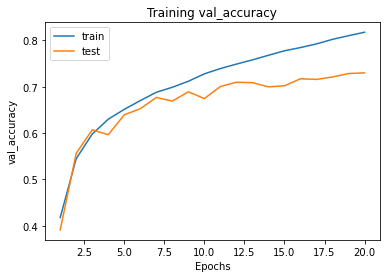

In [ ]:
plot_metric(history2, "accuracy")
plot_metric(history2, "val_accuracy")
plt.legend(["train", "test"])

In [ ]:
# save model 2
model2.save(outputs_dir + "/" + 'model2.h5')

In [ ]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    return model2.predict(image)

## 3. Evaluation

In [ ]:
del X_train
del X_test
del y_train
del y_test

In [ ]:
del clean_imgs

In [ ]:
from tensorflow.keras import datasets

In [ ]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [ ]:
X_train, X_test = X_train / 255.0, X_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

In [ ]:
# load baseline model
import pickle
LR = pickle.load(open(outputs_dir+"/"+"baseline.sav", 'rb'))

In [ ]:
model1 = tf.keras.models.load_model(outputs_dir+"/"+"model1.h5")
loss, acc = model1.evaluate(X_test, y_test, verbose=2)
print('Model1, accuracy: {:5.2f}%'.format(100 * acc))

313/313 - 1s - loss: 1.0346 - accuracy: 0.7076 - 1s/epoch - 3ms/step
Model1, accuracy: 70.76%


In [ ]:
#model2 = tf.keras.models.load_model(outputs_dir+"/"+"model2.h5")
loss, acc = model2.evaluate(X_test, y_test, verbose=2)
print('Model2, accuracy: {:5.2f}%'.format(100 * acc))

313/313 - 1s - loss: 0.8099 - accuracy: 0.7747 - 1s/epoch - 4ms/step
Model2, accuracy: 77.47%


In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
del aug_imgs
del clean_imgs
del noisy_imgs

In [ ]:
np.array_equal(combined_imgs[:50000], X_train)

True

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
def eval_CNN(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = np.argmax(model(test_imgs), axis=-1)
    print(classification_report(y_true, y_pred))

### 3.1 Logistic Regression on Unseen Test Set

Do not run the following cell.

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

### 3.2 Logistic Regression on Augmented Dataset

In [ ]:
evaluation(baseline_model, y_test, X_test)

              precision    recall  f1-score   support

         0.0       0.25      0.35      0.29      2507
         1.0       0.17      0.18      0.17      2539
         2.0       0.12      0.07      0.08      2567
         3.0       0.14      0.11      0.12      2483
         4.0       0.21      0.33      0.26      2539
         5.0       0.18      0.09      0.12      2375
         6.0       0.20      0.33      0.25      2533
         7.0       0.28      0.07      0.12      2520
         8.0       0.22      0.34      0.27      2466
         9.0       0.19      0.14      0.16      2471

    accuracy                           0.20     25000
   macro avg       0.20      0.20      0.18     25000
weighted avg       0.20      0.20      0.18     25000



### 3.3 Model 1 on Augmented Dataset

In [ ]:
eval_CNN(model_I, y_test, X_test_norm)

              precision    recall  f1-score   support

         0.0       0.56      0.46      0.50      2507
         1.0       0.60      0.56      0.58      2539
         2.0       0.48      0.34      0.40      2567
         3.0       0.33      0.33      0.33      2483
         4.0       0.43      0.40      0.42      2539
         5.0       0.48      0.22      0.31      2375
         6.0       0.31      0.71      0.43      2533
         7.0       0.61      0.37      0.46      2520
         8.0       0.48      0.61      0.53      2466
         9.0       0.58      0.56      0.57      2471

    accuracy                           0.46     25000
   macro avg       0.49      0.46      0.45     25000
weighted avg       0.49      0.46      0.45     25000

